In [18]:
import pandas as pd

In [19]:
data_path = "graph_edges.xlsx"
graph_data = pd.read_excel(data_path)
graph_data.head()


,Source,Target
0,61550283796273,100088594703151
1,61550283796273,61550283796273
2,61550283796273,100008345610005
3,61550283796273,61556738729809
4,61550283796273,100095103133859


In [20]:
import networkx as nx

# Create a graph from the dataframe
G = nx.from_pandas_edgelist(graph_data, 'Source', 'Target')

# Display basic information about the graph
G_info = {
    'Number of Nodes': G.number_of_nodes(),
    'Number of Edges': G.number_of_edges(),
    'Sample Nodes': list(G.nodes())[:5]
}

G_info


{'Number of Nodes': 398,
 'Number of Edges': 4011,
 'Sample Nodes': [61550283796273,
  100088594703151,
  100008345610005,
  61556738729809,
  100095103133859]}

In [21]:
import torch
from torch_geometric.utils import from_networkx

# Convert the networkx graph to a torch_geometric data object
data = from_networkx(G)

# Optional: Adding node features (e.g., one-hot encoded node degrees)
degree = torch.tensor([d for n, d in G.degree()], dtype=torch.float)
data.x = degree.unsqueeze(1)  # Node feature matrix with shape [num_nodes, num_node_features]



In [22]:
num_nodes = data.num_nodes
num_train = int(num_nodes * 0.8)
num_val = int(num_nodes * 0.1)

# Generate random indices
indices = torch.randperm(num_nodes)

# Assign masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[indices[:num_train]] = True
data.val_mask[indices[num_train:num_train + num_val]] = True
data.test_mask[indices[num_train + num_val:]] = True


In [23]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# Assuming a binary classification problem (change num_classes accordingly)
model = GCN(num_features=1, num_classes=2)


In [24]:
from torch_geometric.nn import SAGEConv

class EnhancedGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(EnhancedGCN, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)
        self.conv2 = SAGEConv(16, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
# model = EnhancedGCN(num_features=1, num_classes=2)

In [25]:
data.y = torch.randint(0, 2, (data.num_nodes,), dtype=torch.long)

if data.y is None:
    raise ValueError("Node labels (data.y) are not defined.")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()  # Using Negative Log Likelihood Loss

for epoch in range(5000):  # Adjust epochs as necessary
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = torch.max(out, dim=1)
        correct = float(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
        acc = correct / int(data.val_mask.sum())

    if epoch % 50 == 0:  # Adjust print frequency to reduce output verbosity
        print(f'Epoch {epoch}: Loss {loss.item()}, Accuracy {acc}')



Epoch 0: Loss 1.3748292922973633, Accuracy 0.5384615384615384
Epoch 50: Loss 0.818077802658081, Accuracy 0.5384615384615384
Epoch 100: Loss 0.7370136380195618, Accuracy 0.48717948717948717
Epoch 150: Loss 0.7074980735778809, Accuracy 0.5128205128205128
Epoch 200: Loss 0.6958290338516235, Accuracy 0.5384615384615384
Epoch 250: Loss 0.6953830122947693, Accuracy 0.5384615384615384
Epoch 300: Loss 0.6883450150489807, Accuracy 0.5384615384615384
Epoch 350: Loss 0.6919291019439697, Accuracy 0.5384615384615384
Epoch 400: Loss 0.6923127174377441, Accuracy 0.5384615384615384
Epoch 450: Loss 0.6937019228935242, Accuracy 0.5384615384615384
Epoch 500: Loss 0.6922672390937805, Accuracy 0.5384615384615384
Epoch 550: Loss 0.6931396126747131, Accuracy 0.5384615384615384
Epoch 600: Loss 0.6928998827934265, Accuracy 0.5384615384615384
Epoch 650: Loss 0.6931877136230469, Accuracy 0.5384615384615384
Epoch 700: Loss 0.6927427053451538, Accuracy 0.5384615384615384
Epoch 750: Loss 0.6917191743850708, Accurac

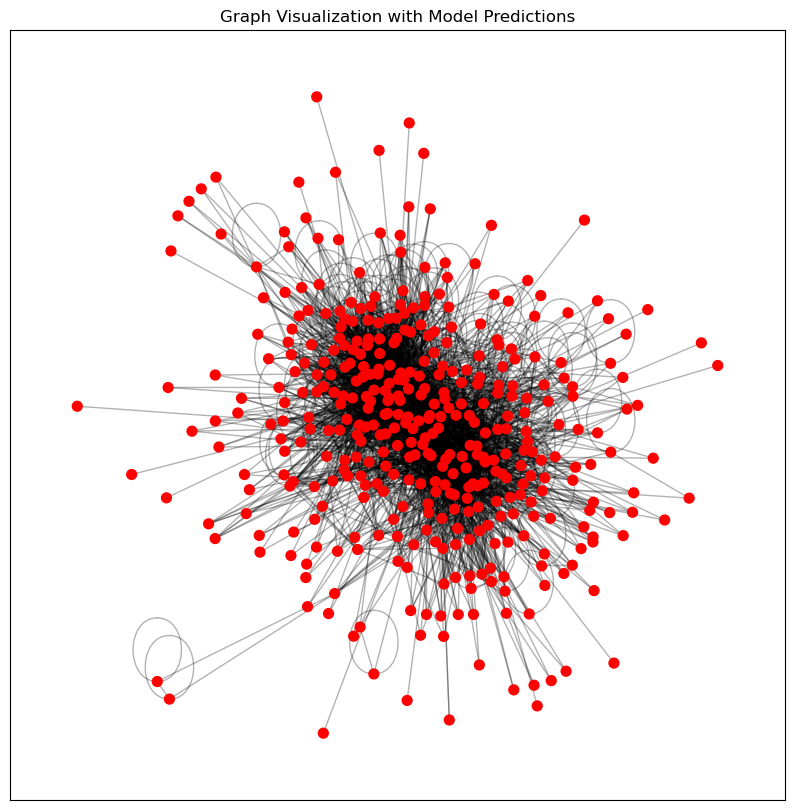

In [26]:
import matplotlib.pyplot as plt
import networkx as nx

# Map predictions to colors
color_map = {0: 'red', 1: 'blue'}  # Four distinct colors for four communities
node_colors = [color_map[p] for p in pred.tolist()]

# Visualize as before
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50)
plt.title('Graph Visualization with Model Predictions')
plt.show()
